# Data Cleaning and Exploratory Data Analysis

This notebook performs data cleaning and exploratory data analysis on the electric vehicle charging stations dataset.


In [1]:
# Install required libraries
import sys
!{sys.executable} -m pip install geopandas pandas matplotlib seaborn scipy --quiet



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Step 1: Read GeoJSON File


In [3]:
# Read the GeoJSON file
gdf = gpd.read_file("Elektrikli Araç Şarj İstasyonları Verisi.geojson")

print(f"Total number of stations: {len(gdf)}")
print(f"\nColumns in the dataset:")
print(gdf.columns.tolist())


Total number of stations: 2933

Columns in the dataset:
['ISTASYON_NO', 'AD', 'ADRES', 'DAGITIM_SIRKETI_LISANS_NO', 'DAGITIM_SIRKETI_LISANS_SAHIBI', 'HIZMET_SEKLI', 'AGIL_ISLETMECISI_UNVAN', 'MARKA_TESCIL_BELGESI', 'LONGITUDE', 'LATITUDE', 'geometry']


## Step 2: Select and Rename Columns


In [4]:
# Select only the required columns
columns_to_keep = [
    'ISTASYON_NO',
    'AD',
    'ADRES',
    'AGIL_ISLETMECISI_UNVAN',
    'MARKA_TESCIL_BELGESI',
    'LATITUDE',
    'LONGITUDE'
]

# Create a new DataFrame with selected columns
df = gdf[columns_to_keep].copy()

# Rename columns
df.rename(columns={
    'AGIL_ISLETMECISI_UNVAN': 'operator',
    'MARKA_TESCIL_BELGESI': 'brand'
}, inplace=True)

print("Columns after selection and renaming:")
print(df.columns.tolist())


Columns after selection and renaming:
['ISTASYON_NO', 'AD', 'ADRES', 'operator', 'brand', 'LATITUDE', 'LONGITUDE']


## Step 3: Add 'side' Column (Europe/Asia)


In [5]:
# Add 'side' column based on longitude
# Istanbul's Bosphorus is approximately at longitude 29°
# If LONGITUDE < 29, then it's on the European side, else Asian side
df['side'] = df['LONGITUDE'].apply(lambda x: 'Europe' if x < 29 else 'Asia')

print("Side distribution:")
print(df['side'].value_counts())


Side distribution:
side
Europe    1605
Asia      1328
Name: count, dtype: int64


## Step 4: Feature Engineering - Extract Districts and Categorize Operators


In [6]:
# Extract district names from address field
# District name typically appears before " / İSTANBUL" in the address
import re

def extract_district(address):
    """Extract district name from address string"""
    # Pattern: looks for text between last space and " / İSTANBUL"
    match = re.search(r'(\w+)\s*/\s*İSTANBUL', address)
    if match:
        return match.group(1)
    return 'Unknown'

df['district'] = df['ADRES'].apply(extract_district)

print("Districts extracted:")
print(f"Total unique districts: {df['district'].nunique()}")
print(f"\nTop 10 districts by station count:")
print(df['district'].value_counts().head(10))


Districts extracted:
Total unique districts: 38

Top 10 districts by station count:
district
Başakşehir      259
Küçükçekmece    168
Sarıyer         154
Ataşehir        137
Ümraniye        134
Beylikdüzü      119
Üsküdar         116
Esenyurt        114
Eyüpsultan      106
Pendik          104
Name: count, dtype: int64


In [7]:
# Create operator categories - Top 10 operators + "Others"
operator_counts = df['operator'].value_counts()
top_10_operators = operator_counts.head(10).index.tolist()

def categorize_operator(operator):
    """Categorize operators into top 10 or 'Others'"""
    if operator in top_10_operators:
        return operator
    else:
        return 'Others'

df['operator_category'] = df['operator'].apply(categorize_operator)

print("Operator categories created:")
print(f"Top 10 operators + Others category")
print(f"\nDistribution:")
print(df['operator_category'].value_counts())


Operator categories created:
Top 10 operators + Others category

Distribution:
operator_category
Others                                                                       1517
ZES DİJİTAL TİCARET ANONİM ŞİRKETİ                                            281
VOLTRUN ENERJİ ANONİM ŞİRKETİ                                                 276
EŞARJ ELEKTRİKLİ ARAÇLAR ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ                       161
BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ                                   142
ZEPLİN TURİZM ARAÇ KİRALAMA MOBİLİTE VE ENERJİ YATIRIMLARI ANONİM ŞİRKETİ     125
TRUGO AKILLI ŞARJ ÇÖZÜMLERİ SANAYİ VE TİCARET ANONİM ŞİRKETİ                  118
ARTAŞ ENERJİ YATIRIMLARI SANAYİ VE TİCARET ANONİM ŞİRKETİ                     112
AKSA MÜŞTERİ ÇÖZÜMLERİ ANONİM ŞİRKETİ                                          73
WAT MOBİLİTE ÇÖZÜMLERİ TEKNOLOJİ VE TİCARET ANONİM ŞİRKETİ                     69
MİONTİ ENERJİ VE TEKNOLOJİ ANONİM ŞİRKETİ                                      59
N

In [8]:
# Create shortened operator names for better visualization
operator_short_names = {
    'ZES DİJİTAL TİCARET ANONİM ŞİRKETİ': 'ZES',
    'VOLTRUN ENERJİ ANONİM ŞİRKETİ': 'VOLTRUN',
    'EŞARJ ELEKTRİKLİ ARAÇLAR ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ': 'EŞARJ',
    'BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ': 'BEEFULL',
    'ZEPLİN TURİZM ARAÇ KİRALAMA MOBİLİTE VE ENERJİ YATIRIMLARI ANONİM ŞİRKETİ': 'ZEPLİN',
    'SHARZ OTOMOTİV ENERJİ VE TEKNOLOJİ ANONİM ŞİRKETİ': 'SHARZ',
    'EN YAKIT ANONİM ŞİRKETİ': 'EN YAKIT',
    'VOLNET ENERJİ SİSTEMLERİ SANAYİ TİCARET ANONİM ŞİRKETİ': 'VOLNET',
    'EVS ELEKTRİKLİ ŞARJ SİSTEMLERİ SAN.VE TİC.A.Ş.': 'EVS',
    'MİGEN ENERJİ VE ELEKTRİKLİ ARAÇ ŞARJ HİZMETLERİ ANONİM ŞİRKETİ': 'MİGEN'
}

df['operator_short'] = df['operator'].map(operator_short_names).fillna(df['operator'])

print("Shortened operator names created for top 10 operators")
print("\nSample:")
print(df[['operator', 'operator_short']].drop_duplicates().head(10))


Shortened operator names created for top 10 operators

Sample:
                                             operator  \
0         BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ   
5     FİLOPORT ARAÇ KİRALAMA VE SERVİS ANONİM ŞİRKETİ   
7   VOLNET ENERJİ SİSTEMLERİ SANAYİ TİCARET ANONİM...   
12  SPUR ENERJİ YATIRIMLARI SANAYİ VE TİCARET ANON...   
18               DOĞUŞ DİJİTAL ENERJİ LİMİTED ŞİRKETİ   
23  AYHAN TEKNOLOJİ VE OTOMASYON ÇÖZÜMLERİ ANONİM ...   
24          FZY ENERJİ ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ   
25                 ZES DİJİTAL TİCARET ANONİM ŞİRKETİ   
27          MİONTİ ENERJİ VE TEKNOLOJİ ANONİM ŞİRKETİ   
29  MAGİCLİNE ENERJİ SİSTEMLERİ SANAYİ VE TİCARET ...   

                                       operator_short  
0                                             BEEFULL  
5     FİLOPORT ARAÇ KİRALAMA VE SERVİS ANONİM ŞİRKETİ  
7                                              VOLNET  
12  SPUR ENERJİ YATIRIMLARI SANAYİ VE TİCARET ANON...  
18               DOĞUŞ DİJİTA

## Step 4: Basic EDA


In [9]:
# Display first few rows
print("First 5 rows:")
print(df.head())


First 5 rows:
  ISTASYON_NO                                                AD  \
0    ŞRJ/2140  KMO FENERKÖY KUZEY OHT1, KMO FENERKÖY KUZEY OHT2   
1    ŞRJ/2672                                      CAROUSEL AVM   
2    ŞRJ/2803                            SERENİTY COMFORT HOTEL   
3    ŞRJ/2804                                        MAYİ HOTEL   
4    ŞRJ/2859                             THE İSTANBUL REZİDANS   

                                               ADRES  \
0  Ali Paşa Mahallesi Merkez Saray Sokağı  Y: 351...   
1  Zeytinlik Mahallesi Halit Uşaklıgil Caddesi  N...   
2  Mahmutbey Mahallesi Payami Safa Caddesi  No:16...   
3  Mahmutbey Mahallesi Payami Safa Caddesi  No:25...   
4  Sümer Mahallesi Pr.dr. Turan Güneş Caddesi  No...   

                                      operator    brand   LATITUDE  LONGITUDE  \
0  BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ  beefull  41.121918  28.228961   
1  BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ  beefull  40.977462  28.872781   
2  

In [10]:
# Display basic information
print("DataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISTASYON_NO        2933 non-null   object 
 1   AD                 2933 non-null   object 
 2   ADRES              2933 non-null   object 
 3   operator           2933 non-null   object 
 4   brand              2933 non-null   object 
 5   LATITUDE           2933 non-null   float64
 6   LONGITUDE          2933 non-null   float64
 7   side               2933 non-null   object 
 8   district           2933 non-null   object 
 9   operator_category  2933 non-null   object 
 10  operator_short     2933 non-null   object 
dtypes: float64(2), object(9)
memory usage: 252.2+ KB
None


In [11]:
# Check for missing values
print("Missing values:")
print(df.isna().sum())


Missing values:
ISTASYON_NO          0
AD                   0
ADRES                0
operator             0
brand                0
LATITUDE             0
LONGITUDE            0
side                 0
district             0
operator_category    0
operator_short       0
dtype: int64


In [12]:
# Value counts for operator
print("Operator distribution:")
print(df['operator'].value_counts())


Operator distribution:
operator
ZES DİJİTAL TİCARET ANONİM ŞİRKETİ                                             281
VOLTRUN ENERJİ ANONİM ŞİRKETİ                                                  276
EŞARJ ELEKTRİKLİ ARAÇLAR ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ                        161
BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ                                    142
ZEPLİN TURİZM ARAÇ KİRALAMA MOBİLİTE VE ENERJİ YATIRIMLARI ANONİM ŞİRKETİ      125
                                                                              ... 
SKY WORLD SOLAR ENERJİ ANONIM ŞİRKETİ                                            1
FZY ENERJİ ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ                                        1
KOÇASLANLAR AKARYAKIT ENERJİ PETROL ÜRÜNLERİ SANAYİ TİCARET LİMİTED ŞİRKETİ      1
DUMANOĞLU ENERJİ YATIRIM ANONİM ŞİRKETİ                                          1
YENİ MODEL YAPAY ZEKA VE ROBOTİK TEKNOLOJİ HİZMETLERİ ANONİM ŞİRKETİ             1
Name: count, Length: 133, dtype: int64


In [13]:
# Value counts for side
print("Side distribution:")
print(df['side'].value_counts())


Side distribution:
side
Europe    1605
Asia      1328
Name: count, dtype: int64


## Step 5: Visualizations


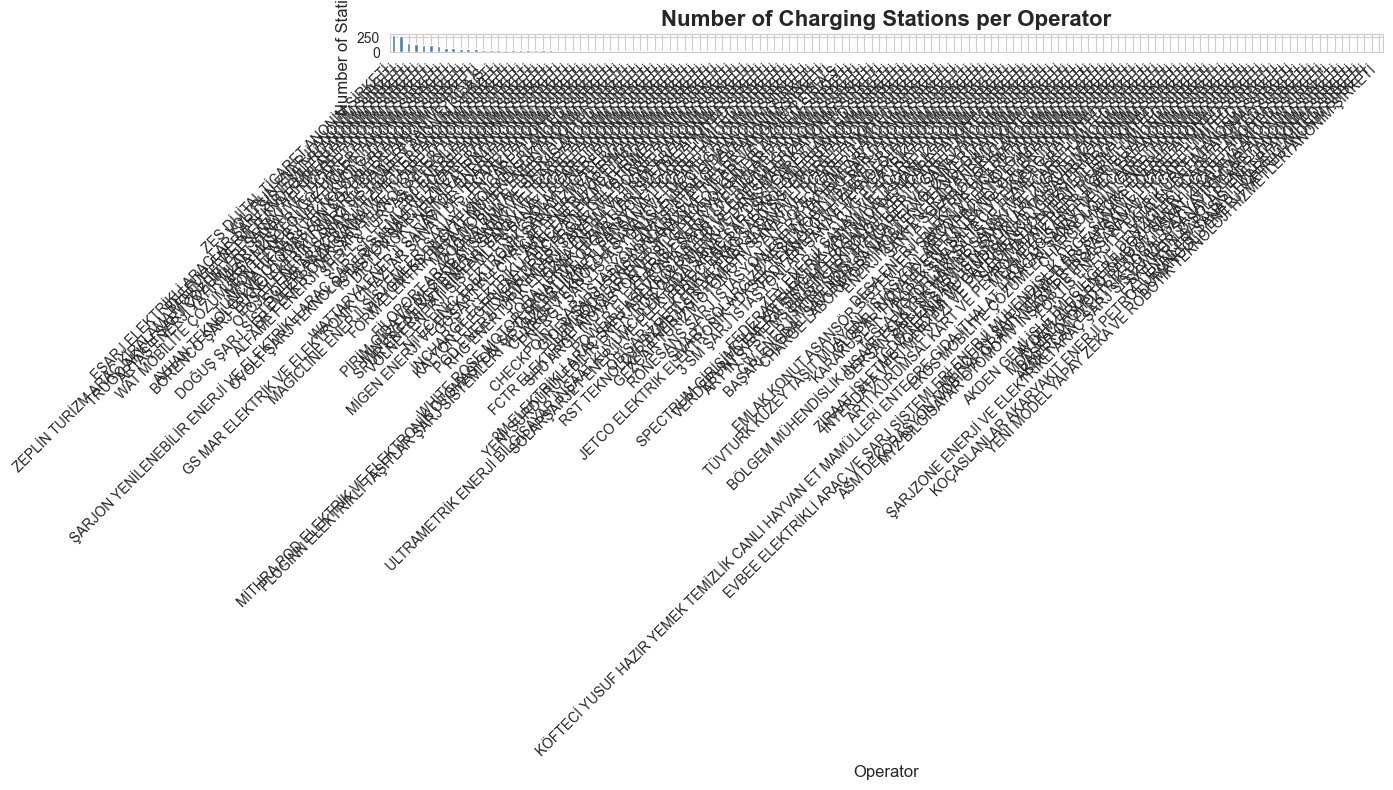


Total number of unique operators: 133


In [14]:
# Bar chart: Number of stations per operator
operator_counts = df['operator'].value_counts()

plt.figure(figsize=(14, 8))
operator_counts.plot(kind='bar', color='steelblue')
plt.title('Number of Charging Stations per Operator', fontsize=16, fontweight='bold')
plt.xlabel('Operator', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal number of unique operators: {df['operator'].nunique()}")


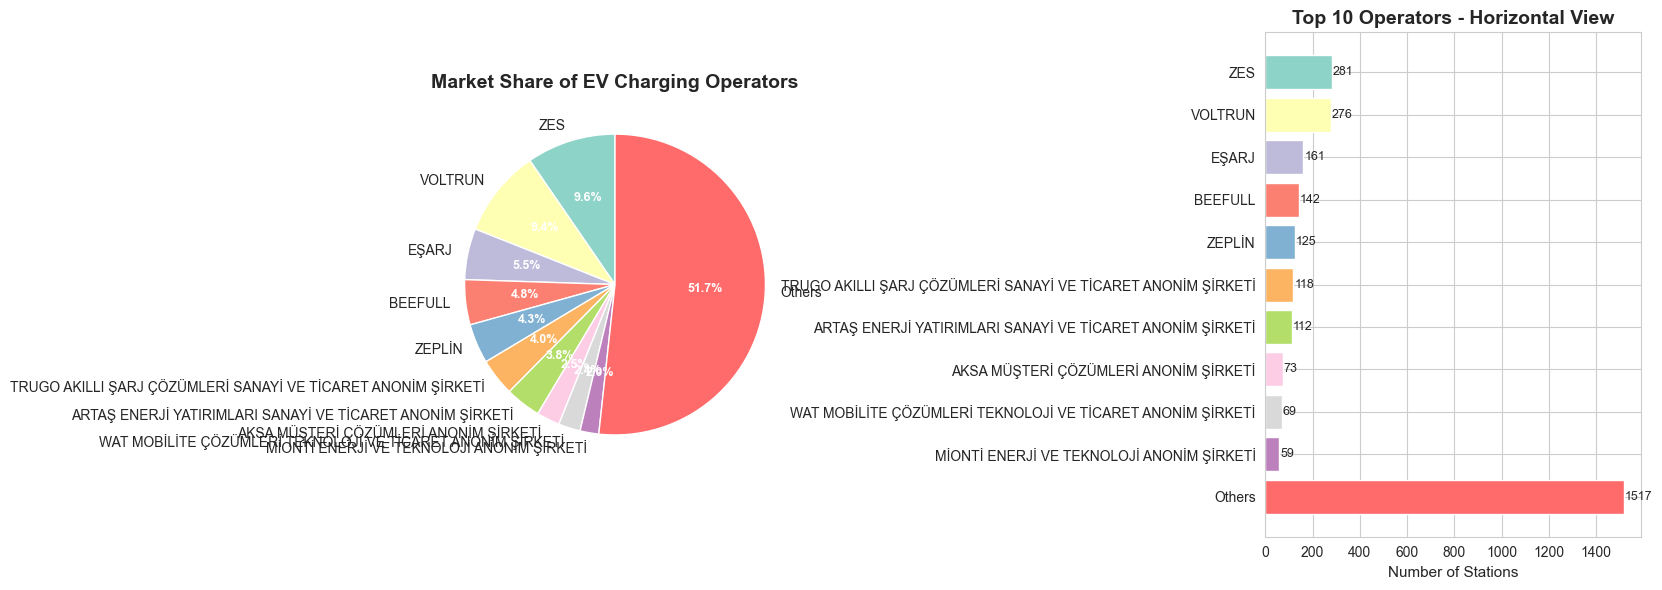

In [15]:
# Market share pie chart for top operators
# Recreate plot_data_short for this cell
operator_counts = df['operator'].value_counts()
top_10 = operator_counts.head(10)
others_count = operator_counts[10:].sum()
plot_data = pd.concat([top_10, pd.Series({'Others': others_count})])
plot_data_short = plot_data.copy()
plot_data_short.index = [operator_short_names.get(idx, idx) if idx != 'Others' else 'Others' for idx in plot_data.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart with top 10 + Others
colors = plt.cm.Set3(range(len(plot_data_short)))
colors[-1] = (1, 0.42, 0.42, 1)  # Red for Others

wedges, texts, autotexts = ax1.pie(plot_data_short.values, labels=plot_data_short.index, 
                                      autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Market Share of EV Charging Operators', fontsize=14, fontweight='bold')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# Horizontal bar chart for better readability
ax2.barh(range(len(plot_data_short)), plot_data_short.values, color=colors)
ax2.set_yticks(range(len(plot_data_short)))
ax2.set_yticklabels(plot_data_short.index)
ax2.set_xlabel('Number of Stations', fontsize=11)
ax2.set_title('Top 10 Operators - Horizontal View', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Add value labels
for i, value in enumerate(plot_data_short.values):
    ax2.text(value + 5, i, f'{int(value)}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


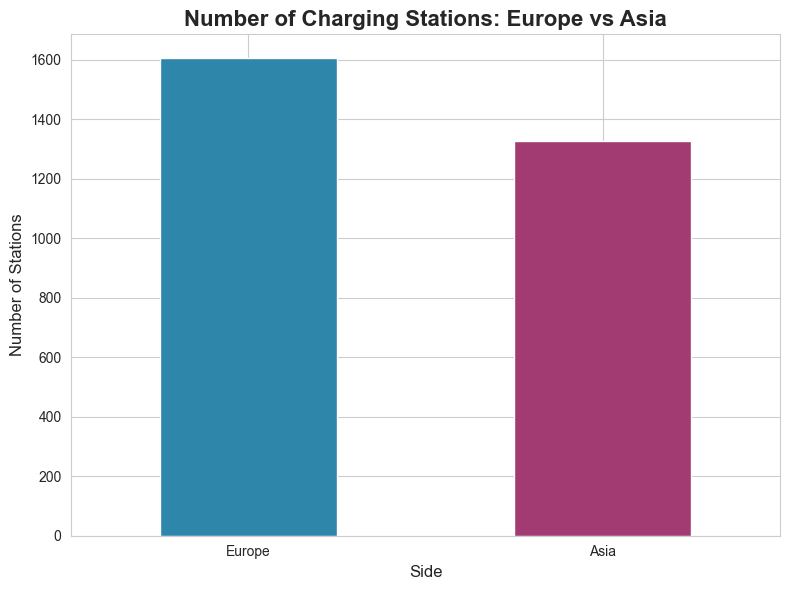


Europe: 1605 stations
Asia: 1328 stations


In [16]:
# Bar chart: Number of stations per side (Europe vs Asia)
side_counts = df['side'].value_counts()

plt.figure(figsize=(8, 6))
side_counts.plot(kind='bar', color=['#2E86AB', '#A23B72'])
plt.title('Number of Charging Stations: Europe vs Asia', fontsize=16, fontweight='bold')
plt.xlabel('Side', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nEurope: {side_counts.get('Europe', 0)} stations")
print(f"Asia: {side_counts.get('Asia', 0)} stations")


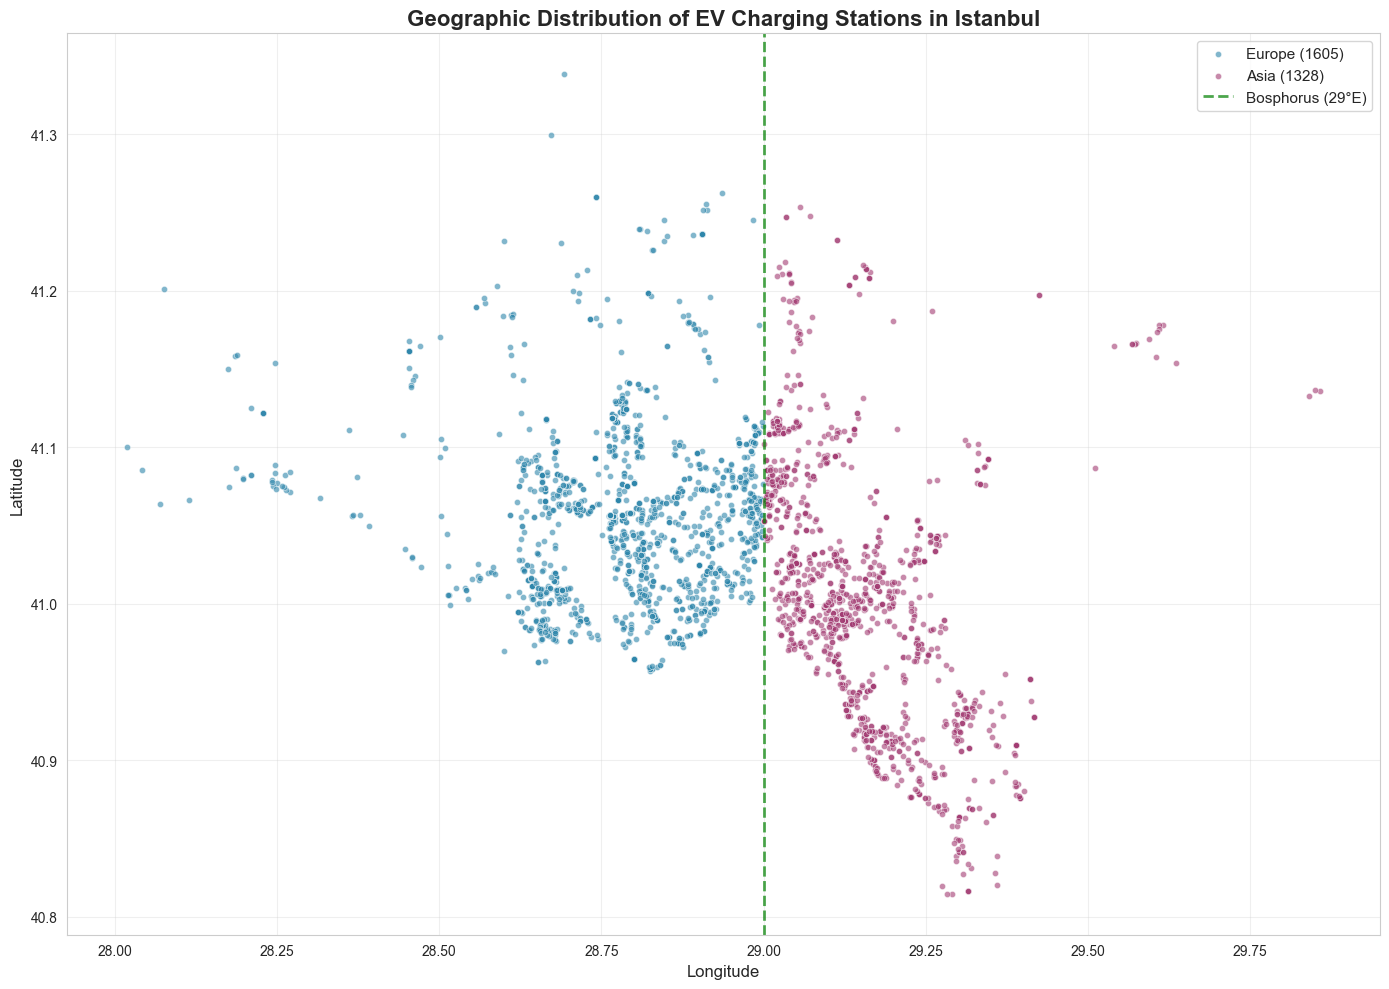


Geographic spread:
Longitude range: 28.0187 to 29.8582
Latitude range: 40.8146 to 41.3381


In [17]:
# Geographic scatter plot - Stations colored by side (Europe vs Asia)
fig, ax = plt.subplots(figsize=(14, 10))

# Plot Europe in blue, Asia in red
europe_stations = df[df['side'] == 'Europe']
asia_stations = df[df['side'] == 'Asia']

ax.scatter(europe_stations['LONGITUDE'], europe_stations['LATITUDE'], 
           c='#2E86AB', alpha=0.6, s=20, label=f'Europe ({len(europe_stations)})', edgecolors='white', linewidth=0.5)
ax.scatter(asia_stations['LONGITUDE'], asia_stations['LATITUDE'], 
           c='#A23B72', alpha=0.6, s=20, label=f'Asia ({len(asia_stations)})', edgecolors='white', linewidth=0.5)

# Add Bosphorus line (longitude = 29)
ax.axvline(x=29, color='green', linestyle='--', linewidth=2, label='Bosphorus (29°E)', alpha=0.7)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Geographic Distribution of EV Charging Stations in Istanbul', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGeographic spread:")
print(f"Longitude range: {df['LONGITUDE'].min():.4f} to {df['LONGITUDE'].max():.4f}")
print(f"Latitude range: {df['LATITUDE'].min():.4f} to {df['LATITUDE'].max():.4f}")


In [18]:
# Note: Service type information is not available in the dataset
# Skipping Service Type Analysis
print("Note: Service type information (Public/Private) is not available in the current dataset.")


Note: Service type information (Public/Private) is not available in the current dataset.


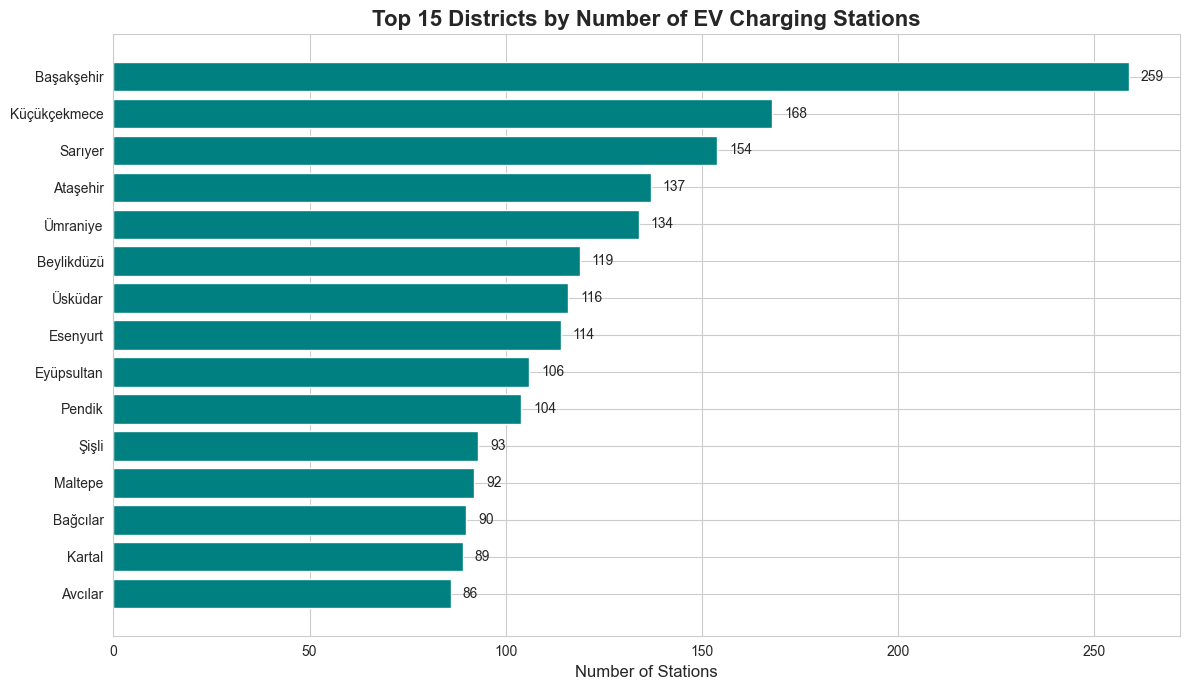


Total districts with stations: 38

Top 5 districts:
  1. Başakşehir: 259 stations (8.8%)
  2. Küçükçekmece: 168 stations (5.7%)
  3. Sarıyer: 154 stations (5.3%)
  4. Ataşehir: 137 stations (4.7%)
  5. Ümraniye: 134 stations (4.6%)


In [19]:
# District Analysis - Top 15 districts
district_counts = df['district'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(district_counts)), district_counts.values, color='teal')
ax.set_yticks(range(len(district_counts)))
ax.set_yticklabels(district_counts.index)
ax.set_xlabel('Number of Stations', fontsize=12)
ax.set_title('Top 15 Districts by Number of EV Charging Stations', fontsize=16, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, value in enumerate(district_counts.values):
    ax.text(value + 3, i, f'{int(value)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTotal districts with stations: {df['district'].nunique()}")
print(f"\nTop 5 districts:")
for i, (district, count) in enumerate(district_counts.head().items(), 1):
    print(f"  {i}. {district}: {count} stations ({count/len(df)*100:.1f}%)")


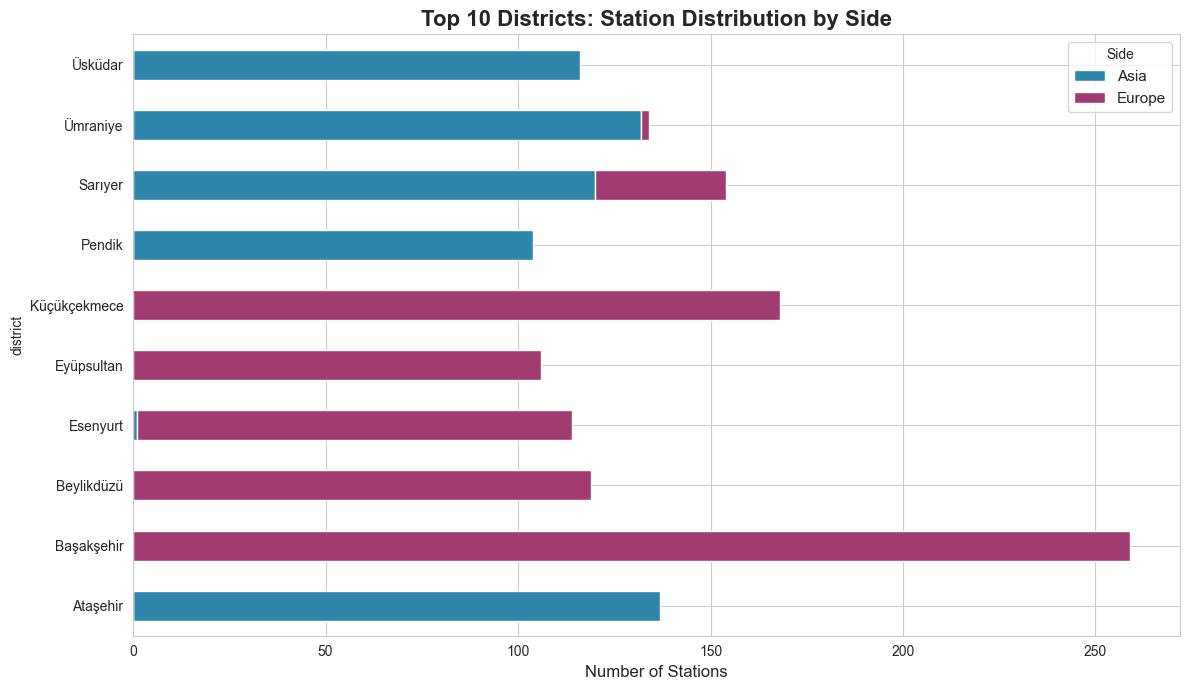


District analysis by side:
side          Asia  Europe
district                  
Ataşehir       137       0
Başakşehir       0     259
Beylikdüzü       0     119
Esenyurt         1     113
Eyüpsultan       0     106
Küçükçekmece     0     168
Pendik         104       0
Sarıyer        120      34
Ümraniye       132       2
Üsküdar        116       0


In [20]:
# District distribution by side
top_10_districts = df['district'].value_counts().head(10).index
top_districts_df = df[df['district'].isin(top_10_districts)]

district_by_side = pd.crosstab(top_districts_df['district'], top_districts_df['side'])

fig, ax = plt.subplots(figsize=(12, 7))
district_by_side.plot(kind='barh', stacked=True, ax=ax, color=['#2E86AB', '#A23B72'])
ax.set_xlabel('Number of Stations', fontsize=12)
ax.set_title('Top 10 Districts: Station Distribution by Side', fontsize=16, fontweight='bold')
ax.legend(title='Side', fontsize=11)

plt.tight_layout()
plt.show()

print("\nDistrict analysis by side:")
print(district_by_side)


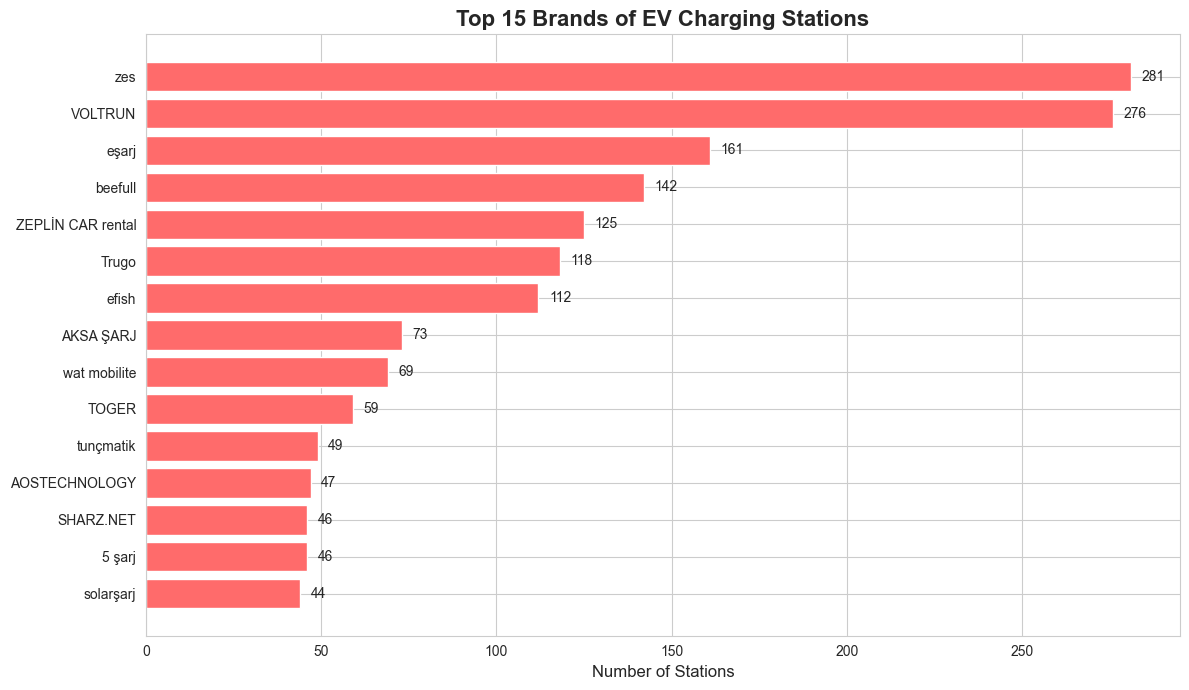


Total unique brands: 134

Top 5 brands:
  1. zes: 281 stations (9.6%)
  2. VOLTRUN: 276 stations (9.4%)
  3. eşarj: 161 stations (5.5%)
  4. beefull: 142 stations (4.8%)
  5. ZEPLİN CAR rental: 125 stations (4.3%)


In [21]:
# Brand Analysis - Top 15 brands
brand_counts = df['brand'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(brand_counts)), brand_counts.values, color='#FF6B6B')
ax.set_yticks(range(len(brand_counts)))
ax.set_yticklabels(brand_counts.index)
ax.set_xlabel('Number of Stations', fontsize=12)
ax.set_title('Top 15 Brands of EV Charging Stations', fontsize=16, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, value in enumerate(brand_counts.values):
    ax.text(value + 3, i, f'{int(value)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTotal unique brands: {df['brand'].nunique()}")
print(f"\nTop 5 brands:")
for i, (brand, count) in enumerate(brand_counts.head().items(), 1):
    print(f"  {i}. {brand}: {count} stations ({count/len(df)*100:.1f}%)")


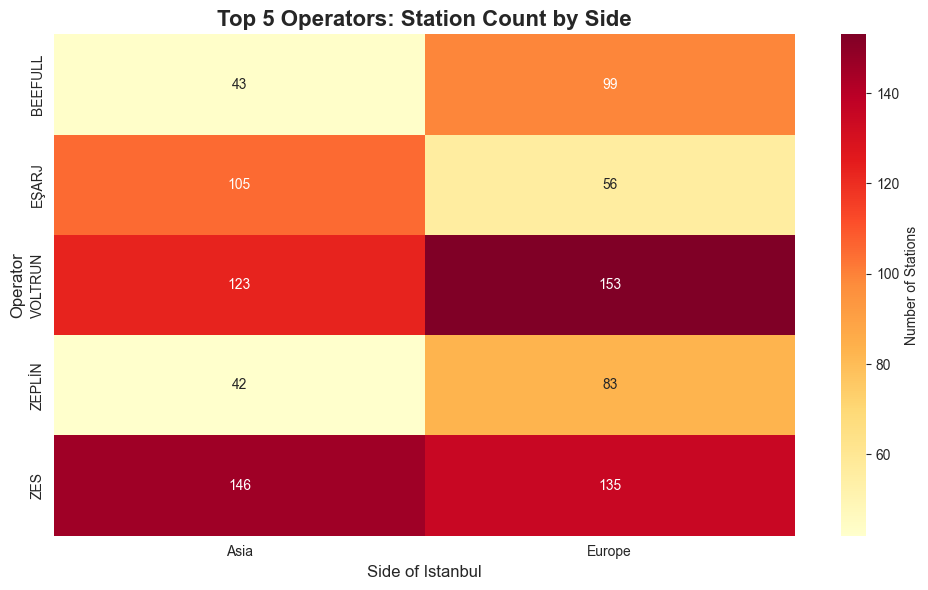


Top 5 operators distribution by side:
side      Asia  Europe
operator              
BEEFULL     43      99
EŞARJ      105      56
VOLTRUN    123     153
ZEPLİN      42      83
ZES        146     135


In [22]:
# Heatmap: Top operators by side
top_5_operators = df['operator'].value_counts().head(5).index
operator_by_side = pd.crosstab(
    df[df['operator'].isin(top_5_operators)]['operator'].map(operator_short_names),
    df[df['operator'].isin(top_5_operators)]['side']
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(operator_by_side, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Stations'}, ax=ax)
ax.set_title('Top 5 Operators: Station Count by Side', fontsize=16, fontweight='bold')
ax.set_xlabel('Side of Istanbul', fontsize=12)
ax.set_ylabel('Operator', fontsize=12)

plt.tight_layout()
plt.show()

print("\nTop 5 operators distribution by side:")
print(operator_by_side)


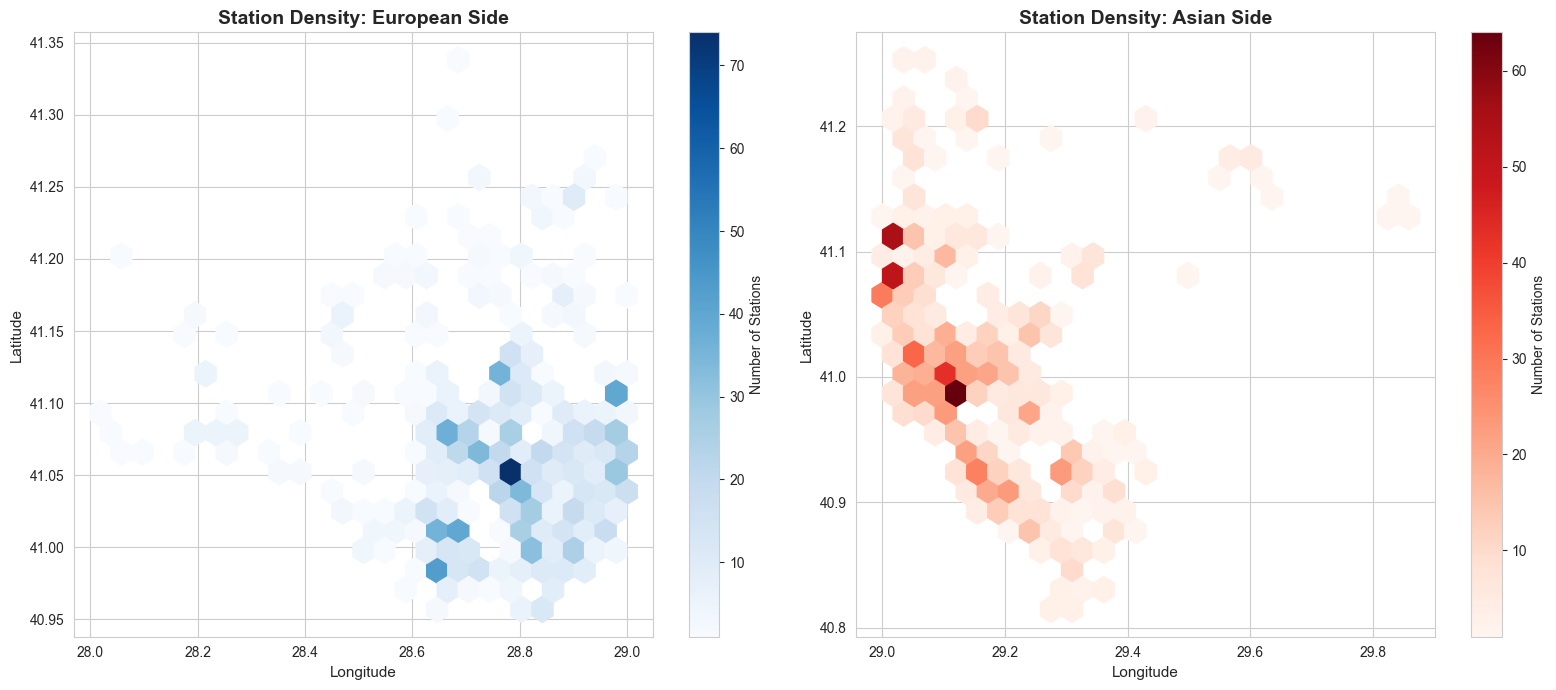


Density Analysis:
European side: 1605 stations across 26 districts
Asian side: 1328 stations across 19 districts


In [23]:
# Geographic density visualization using hexbin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Density plot for Europe
hexbin1 = ax1.hexbin(europe_stations['LONGITUDE'], europe_stations['LATITUDE'], 
                      gridsize=25, cmap='Blues', mincnt=1)
ax1.set_xlabel('Longitude', fontsize=11)
ax1.set_ylabel('Latitude', fontsize=11)
ax1.set_title('Station Density: European Side', fontsize=14, fontweight='bold')
plt.colorbar(hexbin1, ax=ax1, label='Number of Stations')

# Density plot for Asia
hexbin2 = ax2.hexbin(asia_stations['LONGITUDE'], asia_stations['LATITUDE'], 
                      gridsize=25, cmap='Reds', mincnt=1)
ax2.set_xlabel('Longitude', fontsize=11)
ax2.set_ylabel('Latitude', fontsize=11)
ax2.set_title('Station Density: Asian Side', fontsize=14, fontweight='bold')
plt.colorbar(hexbin2, ax=ax2, label='Number of Stations')

plt.tight_layout()
plt.show()

print("\nDensity Analysis:")
print(f"European side: {len(europe_stations)} stations across {europe_stations['district'].nunique()} districts")
print(f"Asian side: {len(asia_stations)} stations across {asia_stations['district'].nunique()} districts")


## Step 7: Summary Statistics


In [24]:
# Comprehensive summary statistics
print("="*70)
print("EV CHARGING STATIONS IN ISTANBUL - COMPREHENSIVE SUMMARY")
print("="*70)

print(f"\n📊 OVERALL STATISTICS:")
print(f"  Total charging stations: {len(df):,}")
print(f"  Total unique operators: {df['operator'].nunique()}")
print(f"  Total unique brands: {df['brand'].nunique()}")
print(f"  Total districts covered: {df['district'].nunique()}")

print(f"\n🌍 GEOGRAPHIC DISTRIBUTION:")
print(f"  European side: {len(europe_stations):,} stations ({len(europe_stations)/len(df)*100:.1f}%)")
print(f"  Asian side: {len(asia_stations):,} stations ({len(asia_stations)/len(df)*100:.1f}%)")
print(f"  Difference: {abs(len(europe_stations) - len(asia_stations)):,} stations")

print(f"\n🏢 TOP 3 OPERATORS:")
for i, (operator, count) in enumerate(operator_counts.head(3).items(), 1):
    short_name = operator_short_names.get(operator, operator)
    print(f"  {i}. {short_name}: {count} stations ({count/len(df)*100:.1f}%)")

print(f"\n🏙️ TOP 3 DISTRICTS:")
for i, (district, count) in enumerate(district_counts.head(3).items(), 1):
    print(f"  {i}. {district}: {count} stations ({count/len(df)*100:.1f}%)")

print(f"\n🏷️ TOP 3 BRANDS:")
for i, (brand, count) in enumerate(brand_counts.head(3).items(), 1):
    print(f"  {i}. {brand}: {count} stations ({count/len(df)*100:.1f}%)")

print(f"\n" + "="*70)


EV CHARGING STATIONS IN ISTANBUL - COMPREHENSIVE SUMMARY

📊 OVERALL STATISTICS:
  Total charging stations: 2,933
  Total unique operators: 133
  Total unique brands: 134
  Total districts covered: 38

🌍 GEOGRAPHIC DISTRIBUTION:
  European side: 1,605 stations (54.7%)
  Asian side: 1,328 stations (45.3%)
  Difference: 277 stations

🏢 TOP 3 OPERATORS:
  1. ZES: 281 stations (9.6%)
  2. VOLTRUN: 276 stations (9.4%)
  3. EŞARJ: 161 stations (5.5%)

🏙️ TOP 3 DISTRICTS:
  1. Başakşehir: 259 stations (8.8%)
  2. Küçükçekmece: 168 stations (5.7%)
  3. Sarıyer: 154 stations (5.3%)

🏷️ TOP 3 BRANDS:
  1. zes: 281 stations (9.6%)
  2. VOLTRUN: 276 stations (9.4%)
  3. eşarj: 161 stations (5.5%)



## Step 6: Save Cleaned Data to CSV


In [25]:
# Save cleaned DataFrame to CSV
df.to_csv('cleaned_stations.csv', index=False, encoding='utf-8')
print("Cleaned data saved to 'cleaned_stations.csv'")
print(f"Total rows saved: {len(df)}")


Cleaned data saved to 'cleaned_stations.csv'
Total rows saved: 2933
